In [1]:
import tensorflow as tf

In [2]:
import os
os.chdir('..')  # Run this only once

In [3]:
from my_io import Dataset
dataset = Dataset('fraction')

prefix is now tmp/0-0
prefix is now tmp/0-1


In [4]:
dataset.data[0]

[False,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True]

In [5]:
from sklearn.model_selection import ShuffleSplit

In [6]:
len(dataset.data)

536

In [7]:
triplets = []
for i in range(dataset.nb_students):
    for j in range(dataset.nb_questions):
        triplets.append((i, j, int(dataset.data[i][j])))

In [8]:
triplets

[(0, 0, 0),
 (0, 1, 0),
 (0, 2, 0),
 (0, 3, 1),
 (0, 4, 0),
 (0, 5, 0),
 (0, 6, 1),
 (0, 7, 1),
 (0, 8, 0),
 (0, 9, 1),
 (0, 10, 1),
 (0, 11, 1),
 (0, 12, 0),
 (0, 13, 1),
 (0, 14, 1),
 (0, 15, 1),
 (0, 16, 0),
 (0, 17, 1),
 (0, 18, 1),
 (0, 19, 1),
 (1, 0, 0),
 (1, 1, 1),
 (1, 2, 1),
 (1, 3, 1),
 (1, 4, 0),
 (1, 5, 1),
 (1, 6, 1),
 (1, 7, 1),
 (1, 8, 1),
 (1, 9, 1),
 (1, 10, 1),
 (1, 11, 1),
 (1, 12, 1),
 (1, 13, 1),
 (1, 14, 1),
 (1, 15, 1),
 (1, 16, 1),
 (1, 17, 1),
 (1, 18, 1),
 (1, 19, 1),
 (2, 0, 0),
 (2, 1, 1),
 (2, 2, 1),
 (2, 3, 1),
 (2, 4, 0),
 (2, 5, 1),
 (2, 6, 1),
 (2, 7, 1),
 (2, 8, 0),
 (2, 9, 0),
 (2, 10, 0),
 (2, 11, 0),
 (2, 12, 0),
 (2, 13, 1),
 (2, 14, 1),
 (2, 15, 1),
 (2, 16, 0),
 (2, 17, 0),
 (2, 18, 0),
 (2, 19, 0),
 (3, 0, 1),
 (3, 1, 1),
 (3, 2, 1),
 (3, 3, 1),
 (3, 4, 1),
 (3, 5, 1),
 (3, 6, 0),
 (3, 7, 1),
 (3, 8, 0),
 (3, 9, 1),
 (3, 10, 1),
 (3, 11, 1),
 (3, 12, 0),
 (3, 13, 1),
 (3, 14, 0),
 (3, 15, 1),
 (3, 16, 0),
 (3, 17, 1),
 (3, 18, 0),
 (3, 19, 1),


## Import Movielens data

In [9]:
import csv

'''triplets = []
with open('/Users/jin/Sites/mangaki/data/ratings-ml.csv') as f:
    reader = csv.reader(f)
    for user_id, work_id, rating in reader:
        triplets.append([int(user_id), int(work_id), 1 if float(rating) >= 2.5 else 0])'''

"triplets = []\nwith open('/Users/jin/Sites/mangaki/data/ratings-ml.csv') as f:\n    reader = csv.reader(f)\n    for user_id, work_id, rating in reader:\n        triplets.append([int(user_id), int(work_id), 1 if float(rating) >= 2.5 else 0])"

In [10]:
k_fold = ShuffleSplit(n_splits=5)

In [11]:
for i_train, i_test in k_fold.split(triplets):  # [:1000]
    pass

In [12]:
import numpy as np

train = np.array(triplets)[i_train]
test = np.array(triplets)[i_test]

In [13]:
import numpy as np
#X = tf.constant(np.array(dataset.data).astype(np.float32))

In [14]:
import csv
import random

def get_train_test(data):
    n = len(data)
    m = len(data[0])
    train = []
    test = []
    for i in range(n):
        for j in range(m):
            if random.random() < 0.9:
                train.append((i, j, int(data[i][j])))
            else:
                test.append((i, j, int(data[i][j])))
    return train, test

In [15]:
def base(i, d):
    v = [0] * d
    v[i] = 1
    return v

In [16]:
#train, test = get_train_test(dataset.data)

In [17]:
NB_USERS = 1 + max(max(train[:, 0]), max(test[:, 0]))
NB_WORKS = 1 + max(max(train[:, 1]), max(test[:, 1]))

def make_hot(triplets):
    data = []
    for i, j, v in triplets:
        data.append((base(i, NB_USERS), base(j, NB_WORKS), v))
    random.shuffle(data)
    return data

In [18]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield len(l[i:i + n]), l[i:i + n]

In [19]:
def get_batches(data):
    return list(map(np.array, zip(*data)))

In [20]:
data = make_hot(train)

In [21]:
N = NB_USERS
R = 8
M = NB_WORKS

In [22]:
N, M

(536, 20)

In [23]:
U = tf.Variable(tf.random_normal([N, R]), name='U')
V = tf.Variable(tf.random_normal([R, M]), name='V')
bias = tf.Variable(tf.random_normal([M, 1]), name='bias')

In [24]:
BATCH_SIZE = 100
E = tf.placeholder(tf.float32, shape=(None, N))
F = tf.placeholder(tf.float32, shape=(None, M))
T = tf.placeholder(tf.float32, shape=None)

In [25]:
pred_without_bias = tf.reduce_sum(tf.matmul(E, U) * tf.matmul(F, tf.transpose(V)), axis=1)
pred = pred_without_bias + tf.reduce_sum(tf.matmul(F, bias), axis=1)

In [26]:
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=T, logits=pred))
regularized_loss = (loss + 0.01 * tf.reduce_mean(tf.square(U))
                         + 0.01 * tf.reduce_mean(tf.abs(V))
                         + 0.01 * tf.reduce_mean(tf.square(bias)))

In [27]:
optimizer = tf.train.AdamOptimizer(0.01)
train_step = optimizer.minimize(regularized_loss, var_list=[U, V, bias])
#train_V_step = optimizer.minimize(negative_log_likelihood, var_list=[V])

In [28]:
init_op = tf.global_variables_initializer()

In [29]:
sess = tf.InteractiveSession()
sess.run(init_op)

In [30]:
test_data = make_hot(test)

In [33]:
for iteration in range(5):
    for size, chunk in chunks(data, BATCH_SIZE):
        if size < BATCH_SIZE:
            break
        eb, fb, vb = get_batches(chunk)
        sess.run(train_step, feed_dict={E: eb, F: fb, T: vb})
        #print(sess.run(loss, feed_dict={E: eb, F: fb, T: vb}))

    if iteration % 1 == 0:
        eb, fb, vb = get_batches(test_data)
        print(iteration, sess.run(loss, feed_dict={E: eb, F: fb, T: vb}))        

0 0.388141
1 0.387026
2 0.387418
3 0.389701
4 0.394108


La bonne nouvelle, c'est qu'on obtient une log-likelihood de -3606 en 20 itérations alors que je viens de check, le package R converge au bout de 210 itérations vers une log-likelihood de -4454.

Reste à savoir si ça généralise bien. (Le package R lui suppose un prior bayésien sur les compétences des gens.)

0.91 1.93 0.12 0.64 0.77 0.44 0.73 0.58 
1.12 2.01 0.02 0.93 1.23 0.07 1.12 1.07 
1.56 1.71 0.09 1.17 0.94 0.63 0.91 0.83 
0.65 0.55 1.30 0.42 1.31 0.98 1.00 0.08 
0.10 1.16 0.47 0.03 0.42 0.32 0.18 0.11 
1.08 1.27 0.28 0.76 0.47 0.12 0.34 0.74 
1.31 1.05 0.19 0.98 1.24 0.83 0.13 0.68 
0.59 0.44 0.75 0.41 1.11 0.47 0.11 0.26 
0.22 0.98 0.90 0.94 0.04 0.27 0.28 0.47 
0.76 0.91 0.05 0.18 1.28 0.49 0.74 0.73 
1.41 0.48 0.51 0.19 1.22 1.01 1.08 0.86 
0.90 0.98 0.39 1.06 0.18 0.85 0.52 0.95 
1.17 1.17 0.76 0.09 0.63 1.04 0.55 0.23 
0.82 1.28 0.73 0.27 0.28 0.84 0.00 1.29 
1.52 1.57 0.63 0.70 0.60 0.64 0.04 0.83 
1.15 0.97 1.05 0.75 0.15 0.01 0.54 0.45 
2.03 0.75 0.24 0.04 1.08 0.35 0.85 0.47 
1.39 0.29 0.44 0.74 1.11 0.18 0.53 0.99 
1.58 0.81 0.50 1.24 1.06 0.24 0.08 0.71 
1.60 0.64 0.48 0.12 1.03 1.11 0.76 0.84 


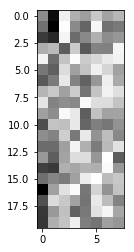

In [34]:
import matplotlib.pyplot as plt

def display(matrix):
    for line in matrix:
        for item in line:
            print('%.2f' % item, end=' ')
        print()

a = np.round(tf.transpose(tf.abs(V)).eval(), 2)
plt.imshow(a, cmap='binary')
display(a)
plt.show()

In [38]:
U.eval().shape

(536, 8)

In [44]:
bias.eval()

array([[-0.10366453],
       [ 0.5037415 ],
       [-0.1371655 ],
       [ 0.4537046 ],
       [-0.06309727],
       [ 2.01602507],
       [-0.86083865],
       [ 1.52988029],
       [ 0.20072113],
       [-1.00156069],
       [ 0.03600097],
       [ 1.48504269],
       [-1.5247246 ],
       [ 1.39627087],
       [-0.4089261 ],
       [ 1.0116533 ],
       [-0.51258725],
       [-0.38125369],
       [-1.58984435],
       [-0.89032906]], dtype=float32)

In [45]:
from collections import namedtuple

GenMA = namedtuple('GenMA', 'U V bias')

backup = GenMA(
    U=U.eval(),
    V=tf.transpose(tf.abs(V)).eval(),
    bias=bias.eval()
)
with open('genma.npy', 'wb') as f:
    np.save(f, backup)

In [51]:
np.random.random(20)

array([ 0.68130257,  0.72677468,  0.65836341,  0.90576629,  0.05221018,
        0.95509969,  0.29322357,  0.12415569,  0.5133218 ,  0.4366922 ,
        0.09395731,  0.89530691,  0.24315185,  0.10563714,  0.64757097,
        0.4182508 ,  0.4477103 ,  0.18880932,  0.02194846,  0.4443673 ])